In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.contrib.tensor_forest.client import random_forest
from tensorflow.python.estimator.inputs import numpy_io

from tensorflow.keras import losses

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import losses

import os

Using TensorFlow backend.


## Helper methods 

In [2]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


In [3]:
def plot_metrics(history):
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Part 1 - Eigenfaces 

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
print(X_train.shape, X_test.shape)
n_components = 150

# Center data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
#Eigen-decomposition
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]

eigenfaces = components.reshape((n_components, h, w))
print(eigenfaces.shape)
print(components.shape)

#project into PCA subspace
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

In [ ]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [ ]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [ ]:
print(ratio_cumsum[:n_components].shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)


correct = predictions==y_test
total_test = len(X_test_transformed)

print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)

In [ ]:
print(classification_report(y_test, predictions, target_names=target_names))

### Re-implementation of PCA in Tensorflow

In [4]:
sess = tf.InteractiveSession()

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
(966, 1850)
(150, 1850)
(966, 1850)
(150, 1850)
(966, 1850, 1850, 150)
(322, 1850, 1850, 150)


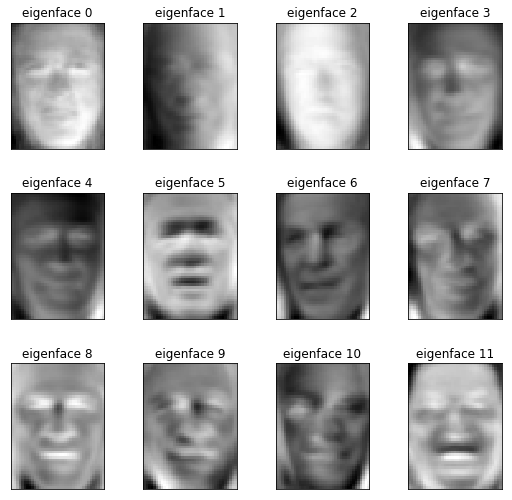

In [5]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
#X = lfw_people.data
X = tf.constant(lfw_people.data.astype(np.float32))
n_features = X.shape[1].value

# the label to predict is the id of the person
y = tf.constant(lfw_people.target.astype(np.float32))
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test set using a stratified k fold
#X = tf.random.shuffle
X_train = X[:966]
X_test = X[966:]
y_train = y[:966]
y_test = y[966:]

print(X_train.shape)
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = tf.reduce_mean(X_train, axis=0)
X_train -= mean
X_test -= mean

# #Eigen-decomposition
S, U, V = tf.linalg.svd(X_train, full_matrices=False)
V = tf.transpose(V)
components = V[:n_components]
print(components.shape)
print(V.shape)
print(V[:n_components].shape)
eigenfaces = tf.reshape(components, [n_components, h,w])

#project into PCA subspace
components = tf.transpose(components)
X_transformed = tf.tensordot(X_train, components, axes=0)
print(X_transformed.shape)
X_test_transformed = tf.tensordot(X_test, components, axes=0)
print(X_test_transformed.shape)

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces.eval(), eigenface_titles, h, w)
plt.show()

In [6]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = tf.math.reduce_sum(explained_variance)
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = tf.math.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)

print('S: ', S.shape)
print('explained var: ', explained_variance.shape)
print('total var: ', total_var.shape)
print('explained var ratio: ', explained_variance_ratio.shape)
print('ratio cumsum: ', ratio_cumsum.shape)
print(ratio_cumsum.eval()[:n_components].shape)

plt.plot(eigenvalueCount, ratio_cumsum.eval()[:n_components])
plt.title('Compactness')
plt.show()

(966,)
S:  (966,)
explained var:  (966,)
total var:  ()
explained var ratio:  (966,)
ratio cumsum:  (966,)
(150,)


## Part 2 - CNNs 
Create a CNN based classifier that out-performs the Eigenfaces algorithm. 
Using either TF or keras, implement the following two CNN based classfies for the same LFW dataset from Part 1

### Gather data

In [44]:
# Gather X, y data (without PCA)
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# Split into a training set and a test set (first 60:20:20 train:test:val split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

# Verify split shape 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
(772, 1850)
(258, 1850)
(258, 1850)


### a) Dense only layers for classification (1 mark)

In [24]:
# Create and train model 
model = keras.Sequential()
model.add(keras.layers.Dense(128, activation=tf.nn.relu, input_shape=X_train[0].shape))
model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
          
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100)

Train on 772 samples, validate on 258 samples
Epoch 1/100
772/772 [==============================] - 0s 344us/step - loss: 1.8945 - acc: 0.3484 - val_loss: 1.7270 - val_acc: 0.4186
Epoch 2/100
772/772 [==============================] - 0s 93us/step - loss: 1.7067 - acc: 0.4223 - val_loss: 1.8113 - val_acc: 0.1899
Epoch 3/100
772/772 [==============================] - 0s 102us/step - loss: 1.6905 - acc: 0.3718 - val_loss: 1.7625 - val_acc: 0.3140
Epoch 4/100
772/772 [==============================] - 0s 100us/step - loss: 1.5858 - acc: 0.4365 - val_loss: 1.4799 - val_acc: 0.5078
Epoch 5/100
772/772 [==============================] - 0s 103us/step - loss: 1.4949 - acc: 0.4806 - val_loss: 1.4481 - val_acc: 0.5078
Epoch 6/100
772/772 [==============================] - 0s 100us/step - loss: 1.4394 - acc: 0.4909 - val_loss: 1.4842 - val_acc: 0.5581
Epoch 7/100
772/772 [==============================] - 0s 99us/step - loss: 1.4436 - acc: 0.4987 - val_loss: 1.4240 - val_acc: 0.5271
Epoch 8/100

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


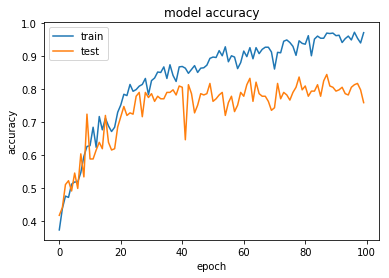

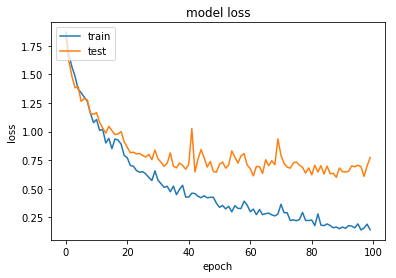

In [22]:
# Plot training metrics 
plot_metrics(history)

In [23]:
# Evaluate model on validation data 
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

258/258 [==============================] - 0s 40us/step
Test accuracy: 0.813953488372093


### b) Two convolution layers of 3x3 with 32 filters each and dense layers for classfication (1 mark)


In [45]:
# Reshape data for 2D convolutions 
X_train = X_train.reshape((len(X_train), h, w))
X_test = X_test.reshape((len(X_test), h, w))
X_val = X_val.reshape((len(X_val), h, w))

X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :,:, np.newaxis]
X_val = X_val[:, :, :, np.newaxis]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (772, 50, 37, 1)
X_test shape: (258, 50, 37, 1)
X_val shape: (258, 50, 37, 1)


In [49]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, 
          y_train,
          validation_data=(X_test, y_test),
          epochs=10)

Train on 772 samples, validate on 258 samples
Epoch 1/10
772/772 [==============================] - 4s 5ms/step - loss: 1.9565 - acc: 0.3484 - val_loss: 1.7490 - val_acc: 0.4186
Epoch 2/10
772/772 [==============================] - 3s 4ms/step - loss: 1.8082 - acc: 0.4041 - val_loss: 1.6175 - val_acc: 0.4225
Epoch 3/10
772/772 [==============================] - 3s 4ms/step - loss: 1.6707 - acc: 0.4365 - val_loss: 1.4959 - val_acc: 0.4457
Epoch 4/10
772/772 [==============================] - 3s 4ms/step - loss: 1.4694 - acc: 0.5026 - val_loss: 1.2860 - val_acc: 0.5078
Epoch 5/10
772/772 [==============================] - 3s 4ms/step - loss: 1.2621 - acc: 0.5803 - val_loss: 1.0616 - val_acc: 0.6705
Epoch 6/10
772/772 [==============================] - 3s 4ms/step - loss: 1.0467 - acc: 0.6231 - val_loss: 0.9280 - val_acc: 0.6822
Epoch 7/10
772/772 [==============================] - 3s 4ms/step - loss: 0.8781 - acc: 0.7060 - val_loss: 0.9432 - val_acc: 0.7248
Epoch 8/10
772/772 [==========

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


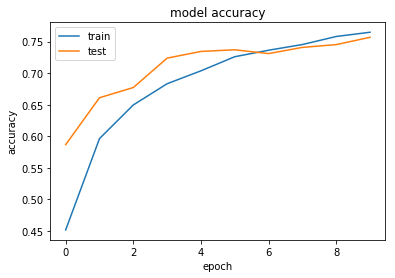

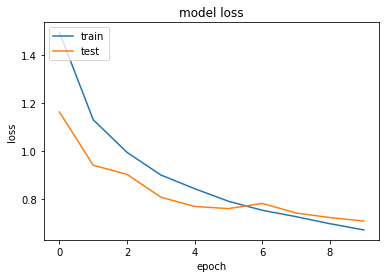

In [54]:
# Plot metrics 
plot_metrics(history)

In [55]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

5000/5000 [==============================] - 4s 886us/step
Test accuracy: 0.7584


### c) Implement the classification of the CIFAR10 dataset using TF or keras. 
You should use as least 3 convlutional layers in your CNN nased classfier. You should also show loss and accuracy curves of the training or the classfication model. You should use proper training, testing and validation datasets and your validational accuracy should reach around 0.8. Usage of pre-built models will
generally not be allowed unless approved by the demonstrator. (3 Marks)

In [3]:
# The data, split, val between train and test sets:
# 10:1:1 train:test_val split 
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Augment data by flipping 
#X_train_flipped = [np.flip(X_train[i],1) for i in X_train[:int(len(X_train)/3)]]

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'val samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
5000 test samples
5000 val samples


In [4]:
#X_train += X_train_flipped
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

X_train /= 255
X_test /= 255
X_val /= 255 

In [5]:
# one-hot encoding: Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Create model 
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
history = model.fit(X_train, y_train,
              batch_size=32,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/10
 5536/50000 [==>...........................] - ETA: 1:49 - loss: 2.0973 - acc: 0.2204

KeyboardInterrupt: 

In [ ]:
plot_metrics(history)

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

In [57]:
X_train[0].shape

(32, 32, 3)

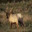

In [73]:
Image.fromarray(X_train[3], mode='RGB')

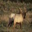

In [75]:
Image.fromarray(np.flip(X_train[3],1), mode='RGB')

In [71]:
X_train[3]

array([[[ 28,  25,  10],
        [ 37,  34,  19],
        [ 38,  35,  20],
        ...,
        [ 76,  67,  39],
        [ 81,  72,  43],
        [ 85,  76,  47]],

       [[ 33,  28,  13],
        [ 34,  30,  14],
        [ 32,  27,  12],
        ...,
        [ 95,  82,  55],
        [ 96,  82,  56],
        [ 85,  72,  45]],

       [[ 39,  32,  15],
        [ 40,  33,  17],
        [ 57,  50,  33],
        ...,
        [ 93,  76,  52],
        [107,  89,  66],
        [ 95,  77,  54]],

       ...,

       [[ 83,  73,  52],
        [ 87,  77,  56],
        [ 84,  74,  52],
        ...,
        [ 99,  93,  70],
        [ 90,  84,  61],
        [ 81,  75,  52]],

       [[ 88,  72,  51],
        [ 90,  74,  52],
        [ 93,  77,  56],
        ...,
        [ 80,  74,  53],
        [ 76,  70,  49],
        [ 82,  76,  55]],

       [[ 97,  78,  56],
        [ 94,  75,  53],
        [ 93,  75,  53],
        ...,
        [ 54,  47,  28],
        [ 63,  56,  37],
        [ 72,  65,  46]]

In [ ]:
len(X_train)